In [3]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
import tree
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation
from omegaconf import OmegaConf
import importlib
import logging
import sys
from collections import defaultdict
import matplotlib.cm as cm


from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from data import digs_data_loader
from model import loss
from experiments import train_se3_diffusion

# Enable logging
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

INFO: Using numpy backend


In [4]:
# Reloads any code changes in the source file.
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(r3_diffuser)
importlib.reload(du)
importlib.reload(plotting)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/experiments/train_se3_diffusion.py'>

In [11]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data
data_conf.rosetta.filtering.subset = 1
data_conf.rosetta.filtering.max_len = 260
data_conf.rosetta.scale_factor = 5.0

# Diffusion settings
diff_conf = conf.diffuser
diff_conf.diffuse_trans = True  # whether to diffuse translations
diff_conf.diffuse_rot = True  # whether to diffuse rotations

# Noise schedules
diff_conf.rot_schedule = 'logarithmic'
diff_conf.trans_max_b = 20.0
diff_conf.trans_schedule = 'linear'

# Print out the config
# print(OmegaConf.to_yaml(conf))

In [12]:
# Create experiment and data loaders
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)

se3_diff = exp.diffuser
r3_diff = se3_diff._r3_diffuser
so3_diff = se3_diff._so3_diffuser

# Extract Ca positions of protein structure.
train_iter = iter(train_loader)
next_item = next(train_iter)
res_mask = next_item['res_mask'][0, :]
ca_pos = next_item['atom37_pos'][0, :, 1, :][res_mask.bool()]

# SDE time parameters.
num_t = 100
forward_t = np.linspace(1e-5, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t

INFO: Number of model parameters 9373240
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Evaluation saved to: ./results/baseline/18D_09M_2022Y_09h_29m_31s
INFO: Training: 1 examples
INFO: Validation: 4 examples with lengths [152 152 152 152 152 152 152 152 152 152]


In [13]:
gt_rigids_0 = next_item['rigids_0'][0][next_item['res_mask'][0].bool()]
rigid_0 = ru.Rigid.from_tensor_7(gt_rigids_0)

# Real protein

In [14]:
se3_diff._diffuse_trans = True
# Provides true rotations if False.
# Note setting this to True when the true rotation is known doesn't work in our set-up.
se3_diff._diffuse_rot = False  

gt_rigids_0 = next_item['rigids_0'][0][next_item['res_mask'][0].bool()]
rigid_0 = ru.Rigid.from_tensor_7(gt_rigids_0)
# rigid_0 = rigid_0.apply_trans_fn(lambda x: x*10.)

# Reverse diffusion starting from should match real protein.
all_steps = []
# curr_step = se3_diff.sample_ref(n_samples=gt_rigids_0.shape[0], impute=rigid_0)

for i, t in reversed(list(enumerate(forward_t))):
    if t == 1.0:
        curr_step = se3_diff.forward_marginal(
            rigid_0, 1.0
        )[0]
        
        # curr_step = se3_diff.sample_ref(n_samples=gt_rigids_0.shape[0], impute=rigid_0)

        all_steps.append(copy.deepcopy(curr_step.to_tensor_7()))
    else:
        trans_score, rot_score = se3_diff.score(rigid_0, curr_step, t)
        curr_step = se3_diff.reverse(
            rigid_t=curr_step,
            rot_score=rot_score,
            trans_score=trans_score,
            t=t,
            dt=dt,
            center=True
        )
        all_steps.append(copy.deepcopy(curr_step.to_tensor_7()))

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:140: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:140: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.

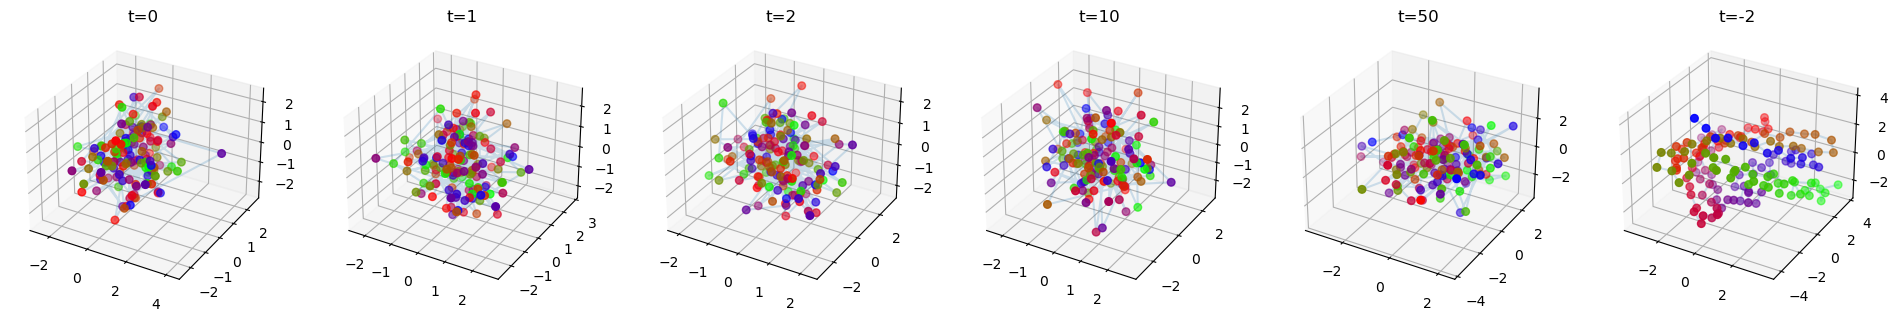

In [17]:
# Plot out SE(3)
final_rigid = all_steps[-2]
res_mask = torch.ones(final_rigid.shape[0])
ts = [0, 1, 2, 10, num_t//2, -2]
f, axes = plt.subplots(1, len(ts), figsize=[24, 8], subplot_kw=dict(projection="3d"))
colors = cm.brg(np.linspace(0, 1, len(final_rigid)))
scale_factor = conf.data.rosetta.scale_factor
# scale_factor = 1.0
ax_lim = 15
# plotting.viz_frames(initial_rigid, res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=4)

def plot(ax, pos, title):
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c=colors, s=30)
    ax.plot(pos[:, 0], pos[:, 1], pos[:, 2], alpha=0.2)
    ax.set_title(title)
    
for i,t in enumerate(ts):
    plot(axes[i], all_steps[t][:, 4:], f't={t}')
    
# plot(axes[1], beg_rigid[:, 4:], f't=2')
# plot(axes[2], mid_rigid[:, 4:], f't={num_t//10}')
# plot(axes[2], mid_rigid[:, 4:], f't={num_t//10}')



# plot(axes[3], final_rigid[:, 4:], 'sample')

# plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
# plotting.viz_frames(rigid_0.to_tensor_7(), res_mask, axes[2], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)

INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


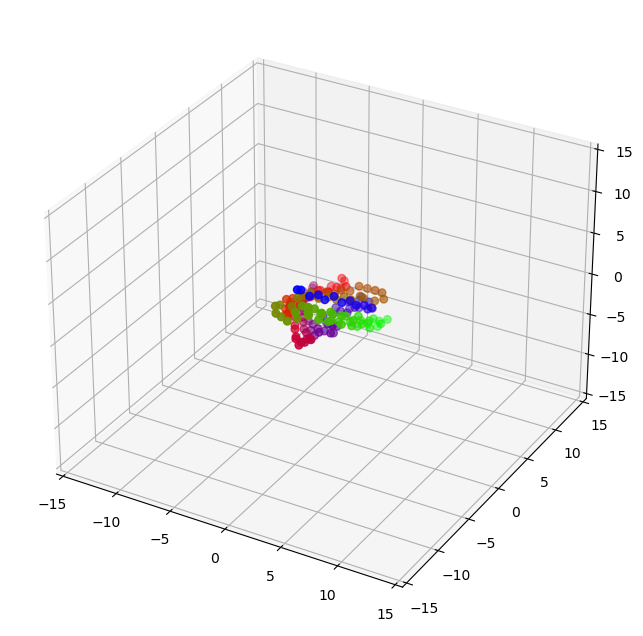

In [18]:
_ = plotting.write_traj(
    torch.stack(all_steps)[:-2],
    f'trans_traj_{diff_conf.trans_schedule}_{diff_conf.trans_max_b}_{data_conf.rosetta.scale_factor}.gif',
    scale_factor=scale_factor,
    se3_vecs=False
)

In [ ]:
_ = plotting.write_traj(
    torch.stack(all_steps)[:-2],
    f'se3_traj_{diff_conf.trans_schedule}_{diff_conf.trans_max_b}.gif',
    scale_factor=scale_factor
)